# PtyPy QC & Ingestion — **Demo Variant**
This notebook demonstrates a minimal, **repo-driven** workflow:
1. **Optionally** generate a *small synthetic dataset* (so the demo runs anywhere).
2. Ingest to a standardized HDF5 using the repo’s CLI.
3. (Optionally) choose an ROI interactively.
4. Run the **repo evaluator** to produce **Outliers**, **STXM**, **DPC‑X**, and **DPC‑Y** maps.
5. Preview outputs.

**Note:** This variant deliberately **does not include any in-notebook fallback evaluator**. It is a demonstration of how to use your workflow as shipped in the repo.


## Prerequisites
- Local clone of `beamline_ptypy_Ingest` (or set `PTYPY_INGEST_REPO`).
- The package/CLIs importable (e.g., `python -m beamline_ptypy_ingest.ingest_hdf5 --help`).
- Evaluator at `ingest/evaluate.py`.


In [1]:
# ---- Config ----
from pathlib import Path
import os, sys

# Repo location
REPO_ROOT = Path(os.environ.get("PTYPY_INGEST_REPO", ".")).resolve()
if (REPO_ROOT / "beamline_ptypy_ingest").exists():
    sys.path.insert(0, str(REPO_ROOT))

# Demo flags
GENERATE_SYNTHETIC = True   # <- set False to use your real RAW_HDF5 below
INTERACTIVE_SCAN_ROI    = False   # <- set False to skip the click-based ROI selection  [CURRENTLY BROKEN!]

# If not generating synthetic data, point RAW_HDF5 at your source file:
RAW_HDF5 = Path(os.environ.get("RAW_HDF5", REPO_ROOT / "tests" / "example_input.h5"))

# Outputs
OUT_DIR      = REPO_ROOT / "qc_outputs_demo"
STD_HDF5     = OUT_DIR / "standardized_demo.h5"
QC_DIR       = OUT_DIR / "qc_run"
OUT_DIR.mkdir(parents=True, exist_ok=True)
QC_DIR.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT =", REPO_ROOT)
print("OUT_DIR   =", OUT_DIR)

# Sanity: required tools
def _require_repo_tools():
    import importlib
    try:
        importlib.import_module('ingest.ingest_hdf5')
    except Exception as e:
        raise RuntimeError("Cannot import 'ingest.ingest_hdf5'. "
                           "Ensure the repo package is on PYTHONPATH or installed.") from e
    eval_py = REPO_ROOT / "ingest" / "evaluate.py"
    if not eval_py.exists():
        raise FileNotFoundError(f"Evaluator not found at {eval_py}")
    return eval_py

EVAL_PY = _require_repo_tools()
print("Evaluator:", EVAL_PY)

REPO_ROOT = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest
OUT_DIR   = /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo
Evaluator: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/ingest/evaluate.py


In [2]:
# ---- (Optional) Generate a tiny synthetic dataset ----
import numpy as np, h5py
from ingest.evaluate import make_synthetic_cxi

if GENERATE_SYNTHETIC:
    RAW_HDF5 = OUT_DIR / "raw_synthetic.h5"
    RAW_HDF5.parent.mkdir(parents=True, exist_ok=True) 
    _ = make_synthetic_cxi(RAW_HDF5)
    print("Synthetic dataset created at:", RAW_HDF5)
else:
    print("Using existing RAW_HDF5:", RAW_HDF5)

Synthetic dataset created at: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/raw_synthetic.h5


Running:
 /Users/gvr/miniconda3/envs/ptypy_full/bin/python -m ingest.ingest_hdf5 --input /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/raw_synthetic.h5 --output /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5 --frames-per-pos 1 --grouping none --roi 256,256 --roi-center 0.5,0.5 --rotate 0 --flip none --sat 65000
Wrote /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5 with shape (256, 256, 256)
Standardised file: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5

Scan positions shape: 256 x 256 (N=65536)
x range (µm): -50.0 → 50.0
y range (µm): -50.0 → 50.0


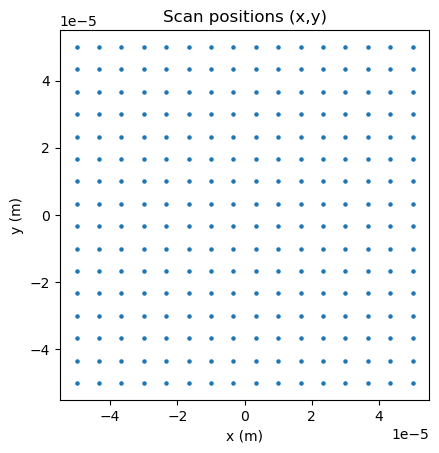

In [3]:
# ---- Ingest to standardized HDF5 (via  CLI) ----
import subprocess, shlex, sys

ROI_NY, ROI_NX = 256, 256    # default ROI size
ROI_CY, ROI_CX = 0.5, 0.5    # default normalized centre, fraction of image size

cmd = [
    sys.executable, "-m", "ingest.ingest_hdf5",
    "--input", str(RAW_HDF5),
    "--output", str(STD_HDF5),
    "--frames-per-pos", "1",
    "--grouping", "none",
    "--roi", f"{ROI_NY},{ROI_NX}",
    "--roi-center", f"{ROI_CY},{ROI_CX}",
    "--rotate", "0",
    "--flip", "none",
    "--sat", "65000"
]
print("Running:\n", " ".join(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)
print("Standardised file:", STD_HDF5)

# quick check of scan dimensions in standardised file
from ingest.evaluate import read_positions
with h5py.File(STD_HDF5, "r") as h5:
    pos_x, pos_y = read_positions(h5, posx_path='/entry/pos', posy_path='/entry/pos')

print(f"\nScan positions shape: {len(pos_x)} x {len(pos_y)} (N={len(pos_x)*len(pos_y)})")
print("x range (µm):", 1.e6*pos_x.min(), "→", 1.e6*pos_x.max())
print("y range (µm):", 1.e6*pos_y.min(), "→", 1.e6*pos_y.max())

import matplotlib.pyplot as plt
plt.scatter(pos_x, pos_y, s=5); 
plt.gca().set_aspect('equal')
plt.title("Scan positions (x,y)"); plt.xlabel("x (m)"); plt.ylabel("y (m)")
plt.show()  # show scan positions


In [4]:
# ---- (Optional) Re-ingest data with reduced ROI in diffraction patterns ----

import h5py, numpy as np, matplotlib.pyplot as plt, subprocess, shlex, sys


ROI_NY, ROI_NX = 64, 64    # reduced diffraction pattern ROI size
ROI_CY, ROI_CX = 0.5, 0.5    # default normalized centre, fraction of image size

# re-run ingest to apply chosen ROI 
cmd = [
    sys.executable, "-m", "ingest.ingest_hdf5",
    "--input", str(RAW_HDF5),
    "--output", str(STD_HDF5),
    "--frames-per-pos", "1",
    "--grouping", "none",
    "--roi", f"{ROI_NY},{ROI_NX}",
    "--roi-center", f"{ROI_CY:.6f},{ROI_CX:.6f}",
    "--rotate", "0",
    "--flip", "none",
    "--sat", "65000"
]
print("Re-running ingest with chosen ROI centre:\n".format(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)


Re-running ingest with chosen ROI centre:

Wrote /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5 with shape (256, 64, 64)


CompletedProcess(args=['/Users/gvr/miniconda3/envs/ptypy_full/bin/python', '-m', 'ingest.ingest_hdf5', '--input', '/Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/raw_synthetic.h5', '--output', '/Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/standardized_demo.h5', '--frames-per-pos', '1', '--grouping', 'none', '--roi', '64,64', '--roi-center', '0.500000,0.500000', '--rotate', '0', '--flip', 'none', '--sat', '65000'], returncode=0)

In [5]:
# ---- Run the evaluator ----
import subprocess, shlex, sys

cmd = [
    sys.executable, str(EVAL_PY), str(STD_HDF5),
    "--data-path", "/entry/data",
    "--pos-x-path", "/entry/pos",
    "--pos-y-path", "/entry/pos",
    "--roi", "256",
    "--bin", "1",
    "--embed-side", "32",
    "--pca-k", "12",
    "--w-feat", "0.5",
    "--reject-topp", "0.02",
    "--emit-ptypy-json", str(QC_DIR / "ptypy_indices.json"),
    "--thumbs-topk", "24",
    "--thumbs-size", "256",
    "--out", str(QC_DIR)
]


print("Running evaluator:\n".format(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)
print("QC outputs written to:", QC_DIR)

Running evaluator:

Outputs in: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/qc_run
QC outputs written to: /Users/gvr/code/hermes_ptypy_ingest/beamline_ptypy_ingest/qc_outputs_demo/qc_run


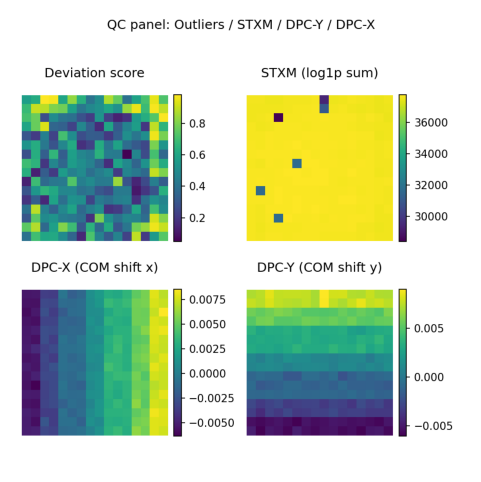

In [9]:
# ---- Preview results ----
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

panel = QC_DIR / "qc_maps.png"
if panel.exists():
    img = mpimg.imread(panel)
    plt.figure(figsize=(6,6))
    plt.imshow(img); plt.axis('off')
    #plt.title("QC panel: Outliers / STXM / DPC-Y / DPC-X")
    plt.show()
else:
    print("qc_maps.png not found in", QC_DIR)

In [7]:
# ---- (Optional) Interactive scan ROI  selection ----
# Click on the image to set the ROI centre; close figure to continue.
# This updates the standardized file by re-running ingest with the chosen centre.
import h5py, numpy as np, matplotlib.pyplot as plt, subprocess, shlex, sys

if INTERACTIVE_ROI:
    with h5py.File(STD_HDF5, 'r') as h5:
        ref = h5['/entry/data'][0]
    roi_size = [ROI_NY, ROI_NX]
    roi_center_px = [ref.shape[0]//2, ref.shape[1]//2]  # [cy, cx]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(np.log1p(ref), origin='lower')
    marker = ax.plot([roi_center_px[1]], [roi_center_px[0]], 'o')[0]
    rect = plt.Rectangle((roi_center_px[1]-roi_size[1]/2, roi_center_px[0]-roi_size[0]/2),
                         roi_size[1], roi_size[0], fill=False, lw=1.5)
    ax.add_patch(rect)
    ax.set_title("Click to set ROI centre (close figure when done)")

    def onclick(event):
        if not event.inaxes:
            return
        roi_center_px[0] = int(round(event.ydata))
        roi_center_px[1] = int(round(event.xdata))
        marker.set_data([roi_center_px[1]],[roi_center_px[0]])
        rect.set_xy((roi_center_px[1]-roi_size[1]/2, roi_center_px[0]-roi_size[0]/2))
        fig.canvas.draw_idle()

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

    # convert to normalized centre
    ny, nx = ref.shape
    ROI_CY = roi_center_px[0]/ny
    ROI_CX = roi_center_px[1]/nx
    print("Chosen normalized ROI centre:", (ROI_CY, ROI_CX))

else:
    print("INTERACTIVE_ROI is False — using default ROI centre:", (ROI_CY, ROI_CX))


# re-run ingest to apply chosen centre
cmd = [
    sys.executable, "-m", "ingest.ingest_hdf5",
    "--input", str(RAW_HDF5),
    "--output", str(STD_HDF5),
    "--frames-per-pos", "1",
    "--grouping", "none",
    "--roi", f"{ROI_NY},{ROI_NX}",
    "--roi-center", f"{ROI_CY:.6f},{ROI_CX:.6f}",
    "--rotate", "0",
    "--flip", "none",
    "--sat", "65000"
]
print("Re-running ingest with chosen ROI centre:\n".format(shlex.quote(c) for c in cmd))
subprocess.run(cmd, check=True)

# check of scan dimensions after ROI update and re-ingest
from ingest.evaluate import read_positions
with h5py.File(STD_HDF5, "r") as h5:
    pos_x, pos_y = read_positions(h5, posx_path='/entry/pos', posy_path='/entry/pos')

import matplotlib.pyplot as plt
plt.scatter(pos_x, pos_y, s=5); 
plt.gca().set_aspect('equal')
plt.title("Scan positions (x,y)"); plt.xlabel("x (m)"); plt.ylabel("y (m)")
plt.show()  # show scan positions

NameError: name 'INTERACTIVE_ROI' is not defined